In [1]:
window_size = [7,14,30,60]
num_features = 8 #depends on how much features we have
output_days = 7
output_features = 2 #min and max

Meta Model building

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models

In [3]:
def baseline_LSTM_model(window_size, num_features, output_days, output_features):
    model = models.Sequential()
    model.add(layers.LSTM(100, input_shape=(window_size, num_features), return_sequences=True))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(output_days * output_features))  # Output for 7 days * 2 features (min and max)
    model.add(layers.Reshape((output_days, output_features)))
    function_name = baseline_LSTM_model.__name__
    return model, function_name

In [4]:
def baseline_GRU_model(window_size, num_features, output_days, output_features):
    model = models.Sequential()
    model.add(layers.GRU(100, input_shape=(window_size, num_features), return_sequences=False))
    model.add(layers.Dense(output_days * output_features))  # Output for 7 days * 2 features (min and max)
    model.add(layers.Reshape((output_days, output_features)))
    function_name = baseline_GRU_model.__name__
    return model, function_name

In [5]:
'''
CNN_LSTM mdoel is a combination of CNN and LSTM. CNN is used to extract the features from the input data and LSTM is used to support the sequence data.
'''
def CNN_LSTM_model(window_size, num_features, output_days, output_features):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, num_features)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(100, return_sequences=True))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(output_days*output_features))  # 7 days * 2 targets (High, Low)
    model.add(layers.Reshape((output_days, output_features)))

    function_name = CNN_LSTM_model.__name__
    return model, function_name
#can use KAN, Attenion layer to adjust the weight

In [7]:
# Define the CNN + GRU model
def CNN_GRU_model(window_size, num_features, output_days, output_features):
    model = models.Sequential()
    
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, num_features)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.GRU(100, return_sequences=False))
    
    model.add(layers.Dense(output_days * output_features))  # Output for 7 days * 2 features (min and max)
    
    model.add(layers.Reshape((output_days, output_features)))

    function_name = CNN_GRU_model.__name__
    
    return model,function_name

In [8]:
from tensorflow.keras.layers import Attention
def CNN_LSTM_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    
    # Attention mechanism
    attention = Attention()([x, x])
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(output_days*output_features)(x)
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_LSTM_SA_model.__name__
    return model, function_name

In [9]:
def CNN_GRU_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=True)(x)
    
    attention = layers.Attention()([x, x])  # Self-attention (query = value = x)
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(output_days * output_features)(x)
    
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_GRU_SA_model.__name__
    
    return model,function_name

Meta Model training 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import save_model

def meta_training(model_function,
                loading_path, 
                saving_path, 
                version_name, 
                seed = 42,
                test_size = 0.8,
                epochs = 20,
                batch_size = 8,
                shuffle=True, 
                metrics=['mae'],
                loss = 'mean_squared_error',
                optimizer='adam',
                window_size = window_size, 
                num_features = num_features, 
                output_days = output_days, 
                output_features = output_features):
    
    model_history = []
    
    #create folder to save the model
    model_folder_path = os.path.join(saving_path, version_name, f"_s-{seed}_t-{test_size}_e-{epochs}_b-{batch_size}_S-{shuffle}_m-{metrics}_l-{loss}_o-{optimizer}")

    os.makedirs(model_folder_path, exist_ok=True)
    print(f"Folder '{version_name}' is ready.")


    for window in window_size:
        # Load the data
        X = pd.read_pickle(loading_path + f"X_{window}days_i.pkl")
        y = pd.read_pickle(loading_path + f"y_{window}days_i.pkl")
        print(f"Data for {window} days loaded.")

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=test_size, 
                                                            shuffle=shuffle, 
                                                            random_state=seed)
        print("Data split into training and testing sets.")

        # Train the model
        print("start training:\n")
        model, name = model_function(window, 
                                     num_features, 
                                     output_days, 
                                     output_features)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        history = model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_test, y_test), 
                            verbose=1)
        
        # Save the model    
        model_save_path = os.path.join(model_folder_path, f"{name}_{window}days.h5")
        model.save(model_save_path)
        print(f"Model trained on {window} days has been saved.")

        model_history.append(history)

    return model_history
    

In [11]:
import matplotlib.pyplot as plt
def plot_training_history(mdoel_history, window=window_size):   
    for i in range(len(mdoel_history)):
        plt.title(f"Training and Validation Loss for {window[i]} days")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(mdoel_history[i].history['loss'], label='Training Loss')
        plt.plot(mdoel_history[i].history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # Plot MAE
        plt.title(f"Training and Validation MAE for {window[i]} days")
        plt.subplot(1, 2, 2)
        plt.plot(mdoel_history[i].history['mae'], label='Training MAE')
        plt.plot(mdoel_history[i].history['val_mae'], label='Validation MAE')
        plt.title('MAE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()


Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0350 - mae: 0.1158 - val_loss: 3.2650e-04 - val_mae: 0.0137
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2475e-04 - mae: 0.0138 - val_loss: 3.1857e-04 - val_mae: 0.0136
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4665e-04 - mae: 0.0142 - val_loss: 3.0702e-04 - val_mae: 0.0130
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3261e-04 - mae: 0.0157 - val_loss: 3.1631e-04 - val_mae: 0.0131
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4205e-04 - mae: 0.0157 - val_loss: 2.8155e-04 - val_mae: 0.0124
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0445e-04 - mae: 0.0147 - val_loss: 3.8847e-04 - val_mae: 0.0143
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3589e-04 - mae: 0.0136 - val_loss: 2.7829e-04 - val_mae: 0.0123
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0993e-04 - mae: 0.0153 - val_loss: 2.7362e-04 - val_mae: 0.0121
Epoch 

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0295 - mae: 0.0967 - val_loss: 4.3695e-04 - val_mae: 0.0162
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.1111e-04 - mae: 0.0172 - val_loss: 8.7500e-04 - val_mae: 0.0230
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.2481e-04 - mae: 0.0190 - val_loss: 3.4837e-04 - val_mae: 0.0140
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2307e-04 - mae: 0.0156 - val_loss: 8.4722e-04 - val_mae: 0.0230
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.5168e-04 - mae: 0.0180 - val_loss: 7.8888e-04 - val_mae: 0.0215
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.1413e-04 - mae: 0.0172 - val_loss: 3.2755e-04 - val_mae: 0.0136
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.2786e-04 - mae: 0.0178 - val_loss: 3.3939e-04 - val_mae: 0.0137
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.5740e-04 - mae: 0.0144 - val_loss: 3.2928e-04 - val_mae: 0.0136

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0217 - mae: 0.0863 - val_loss: 5.2475e-04 - val_mae: 0.0177
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.7632e-04 - mae: 0.0194 - val_loss: 4.5398e-04 - val_mae: 0.0163
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.9964e-04 - mae: 0.0199 - val_loss: 3.9694e-04 - val_mae: 0.0155
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.6149e-04 - mae: 0.0160 - val_loss: 3.1796e-04 - val_mae: 0.0134
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.2601e-04 - mae: 0.0155 - val_loss: 0.0018 - val_mae: 0.0358
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.0744e-04 - mae: 0.0208 - val_loss: 2.9973e-04 - val_mae: 0.0128
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.8803e-04 - mae: 0.0146 - val_loss: 3.3906e-04 - val_mae: 0.0138
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.8140e-04 - mae: 0.0167 - val_loss: 5.9186e-04 - val_mae: 0.0191
Epo

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0304 - mae: 0.0982 - val_loss: 6.9796e-04 - val_mae: 0.0206
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 8.1451e-04 - mae: 0.0223 - val_loss: 3.8747e-04 - val_mae: 0.0149
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5.0563e-04 - mae: 0.0169 - val_loss: 4.2553e-04 - val_mae: 0.0156
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 5.4111e-04 - mae: 0.0173 - val_loss: 4.6949e-04 - val_mae: 0.0170
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.7576e-04 - mae: 0.0162 - val_loss: 7.6421e-04 - val_mae: 0.0217
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 6.0140e-04 - mae: 0.0183 - val_loss: 0.0047 - val_mae: 0.0619
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 4.0656e-04 - val_mae: 0.0154
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 3.6151e-04 - mae: 0.0139 - val_loss: 2.7043e-04 - val_mae: 0.0122
Epoch 9

Model trained on 60 days has been saved.


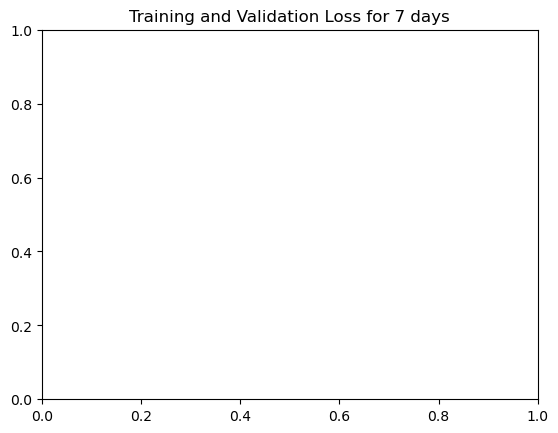

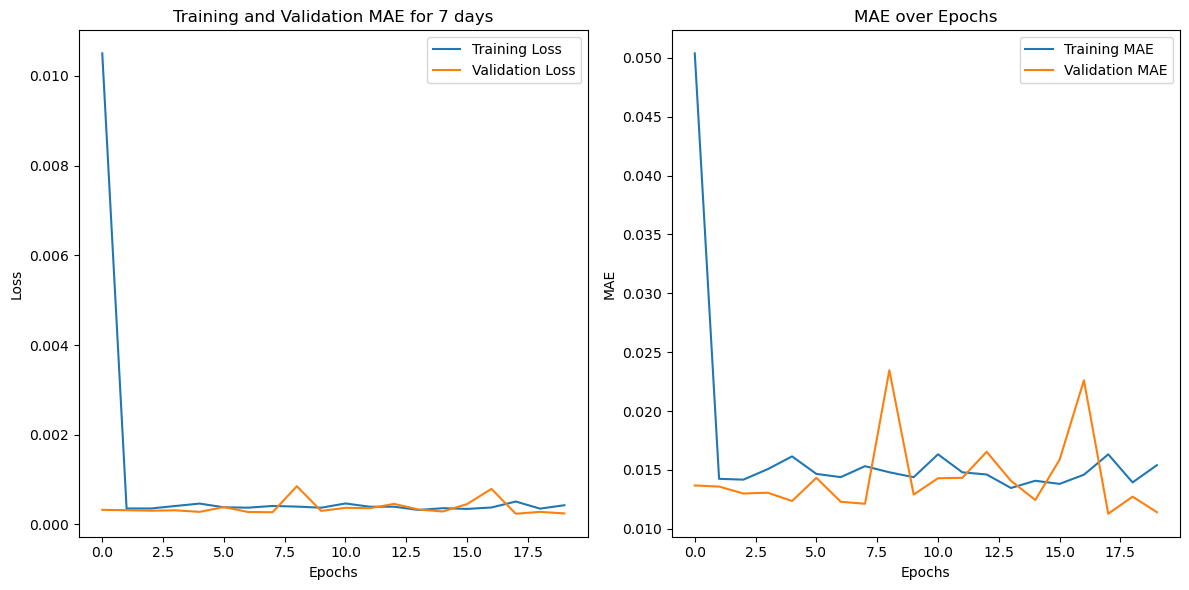

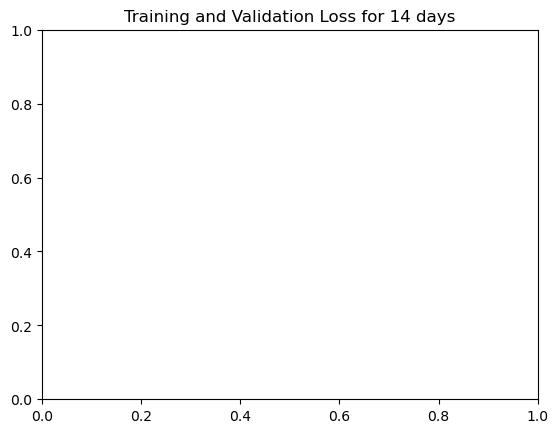

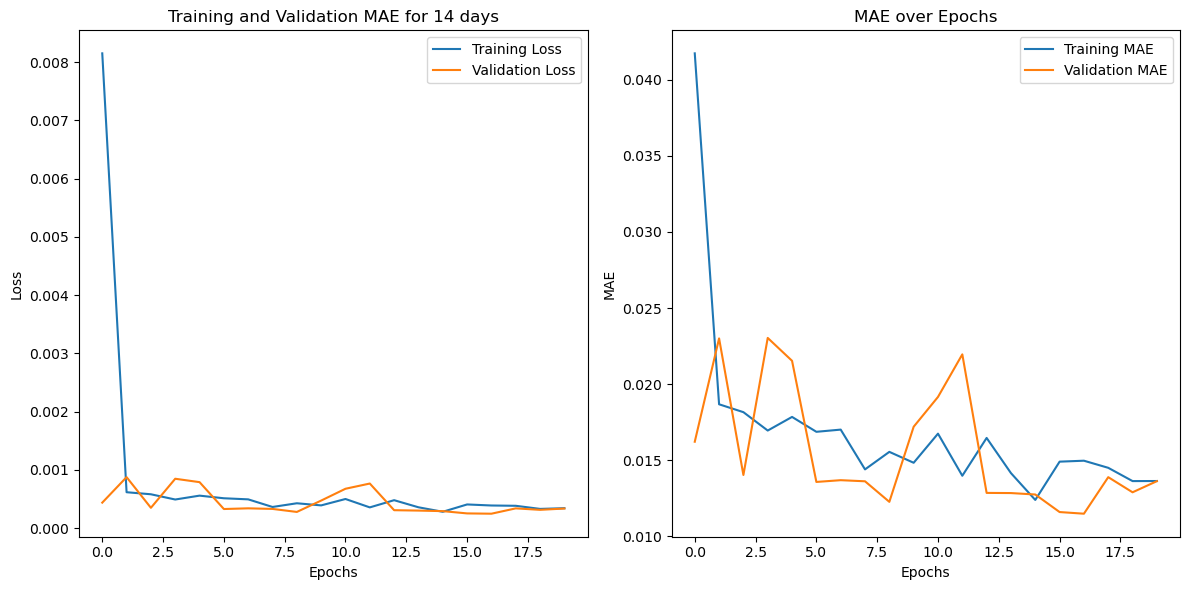

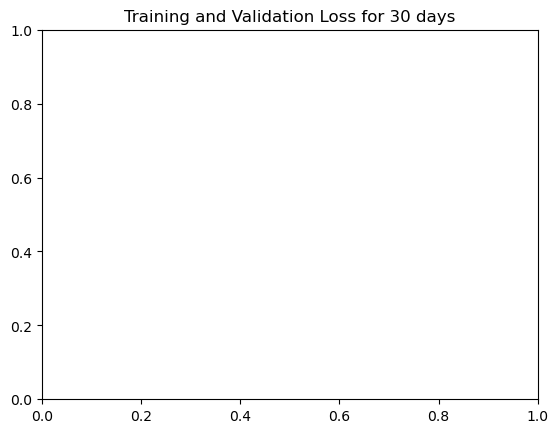

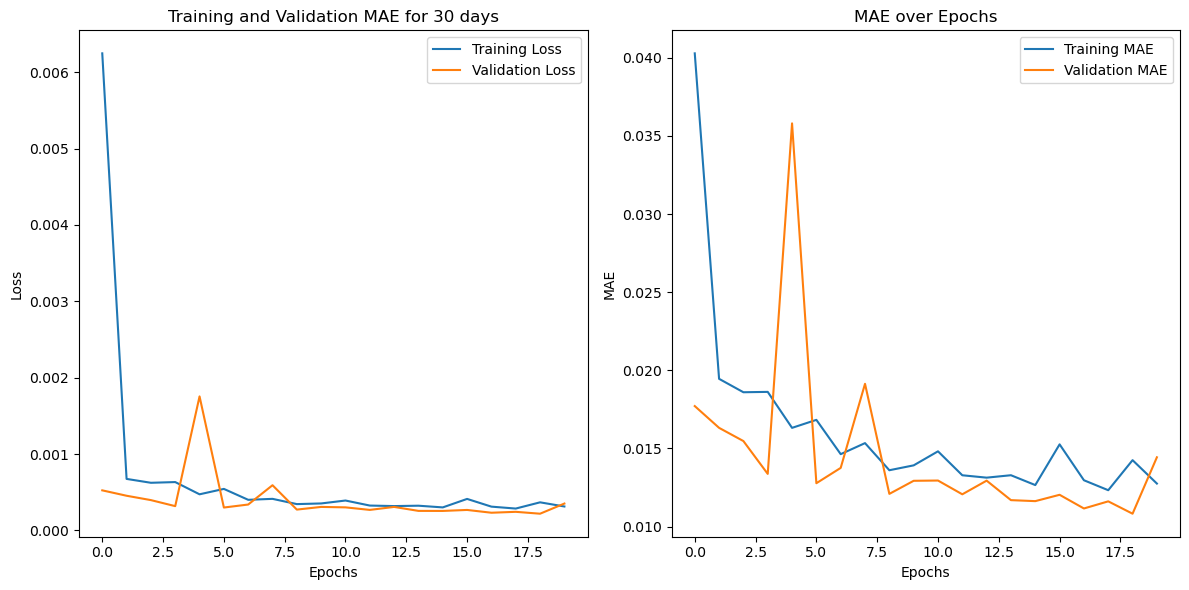

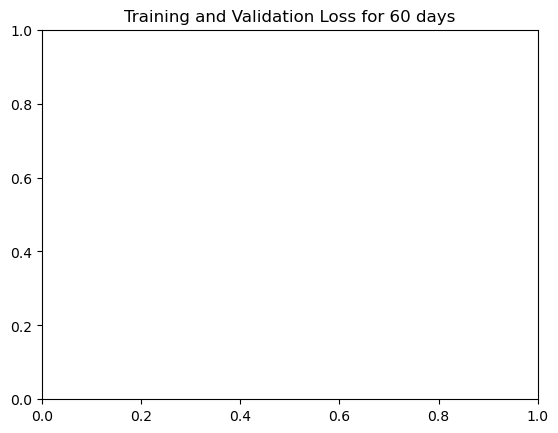

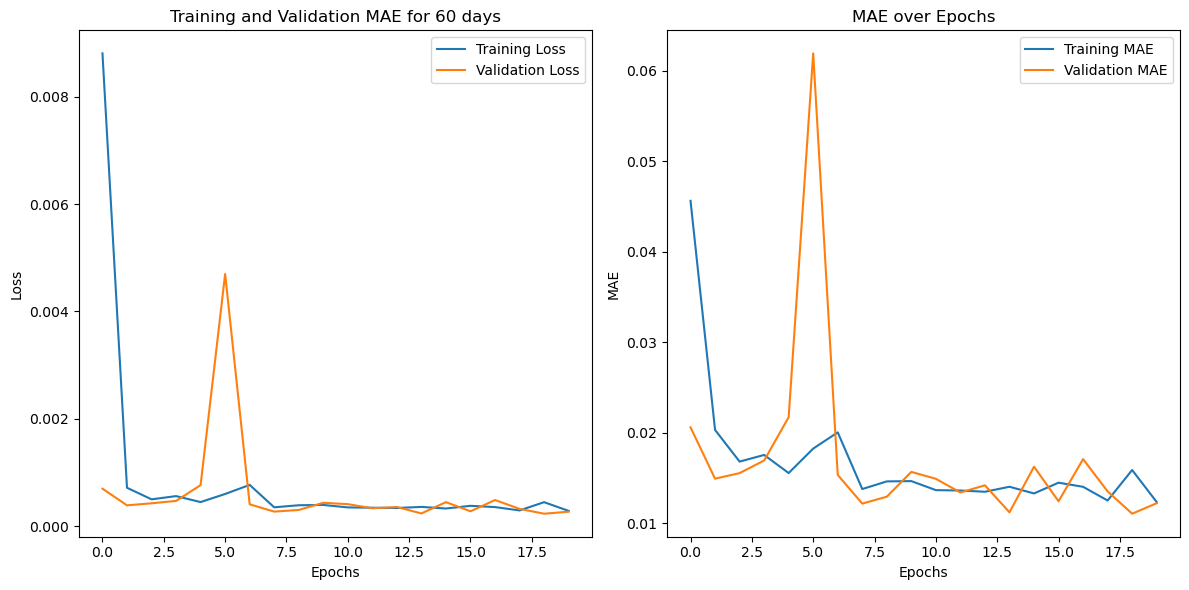

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0405 - mae: 0.1256 - val_loss: 2.5557e-04 - val_mae: 0.0117
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4425e-04 - mae: 0.0115 - val_loss: 2.1276e-04 - val_mae: 0.0106
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4749e-04 - mae: 0.0114 - val_loss: 2.1619e-04 - val_mae: 0.0106
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5323e-04 - mae: 0.0113 - val_loss: 2.4789e-04 - val_mae: 0.0116
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2573e-04 - mae: 0.0108 - val_loss: 2.2420e-04 - val_mae: 0.0110
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3442e-04 - mae: 0.0111 - val_loss: 2.2325e-04 - val_mae: 0.0110
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3689e-04 - mae: 0.0112 - val_loss: 3.2371e-04 - val_mae: 0.0135
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9561e-04 - mae: 0.0125 - val_loss: 1.9757e-04 - val_mae: 0.0100
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0390 - mae: 0.1211 - val_loss: 2.5057e-04 - val_mae: 0.0114
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3673e-04 - mae: 0.0112 - val_loss: 2.2744e-04 - val_mae: 0.0108
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2143e-04 - mae: 0.0109 - val_loss: 2.0739e-04 - val_mae: 0.0103
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0797e-04 - mae: 0.0107 - val_loss: 2.0984e-04 - val_mae: 0.0104
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1174e-04 - mae: 0.0107 - val_loss: 2.2251e-04 - val_mae: 0.0108
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1665e-04 - mae: 0.0108 - val_loss: 1.9026e-04 - val_mae: 0.0098
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9076e-04 - mae: 0.0102 - val_loss: 2.0348e-04 - val_mae: 0.0102
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2216e-04 - mae: 0.0108 - val_loss: 2.0000e-04 - val_mae: 0.0102
Epoch 9

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0321 - mae: 0.1129 - val_loss: 2.6017e-04 - val_mae: 0.0120
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8066e-04 - mae: 0.0121 - val_loss: 2.4723e-04 - val_mae: 0.0116
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4673e-04 - mae: 0.0116 - val_loss: 2.3019e-04 - val_mae: 0.0113
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4591e-04 - mae: 0.0112 - val_loss: 2.1044e-04 - val_mae: 0.0105
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3591e-04 - mae: 0.0111 - val_loss: 1.9746e-04 - val_mae: 0.0103
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4476e-04 - mae: 0.0111 - val_loss: 1.9821e-04 - val_mae: 0.0102
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1221e-04 - mae: 0.0108 - val_loss: 2.7218e-04 - val_mae: 0.0123
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2482e-04 - mae: 0.0109 - val_loss: 2.2078e-04 - val_mae: 0.0110

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0448 - mae: 0.1245 - val_loss: 2.8613e-04 - val_mae: 0.0125
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.2093e-04 - mae: 0.0131 - val_loss: 2.4414e-04 - val_mae: 0.0114
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.2679e-04 - mae: 0.0108 - val_loss: 2.2346e-04 - val_mae: 0.0110
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.9674e-04 - mae: 0.0128 - val_loss: 2.2097e-04 - val_mae: 0.0106
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.2077e-04 - mae: 0.0108 - val_loss: 2.0939e-04 - val_mae: 0.0106
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.4510e-04 - mae: 0.0114 - val_loss: 2.2412e-04 - val_mae: 0.0110
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.5191e-04 - mae: 0.0117 - val_loss: 1.8983e-04 - val_mae: 0.0100
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.6789e-04 - mae: 0.0121 - val_loss: 3.9884e-04 - val_mae: 0.0153

Model trained on 60 days has been saved.


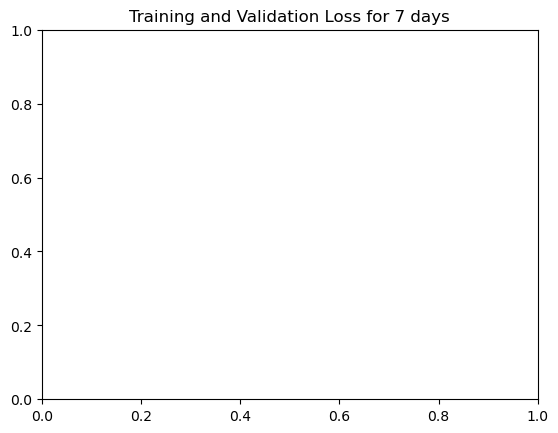

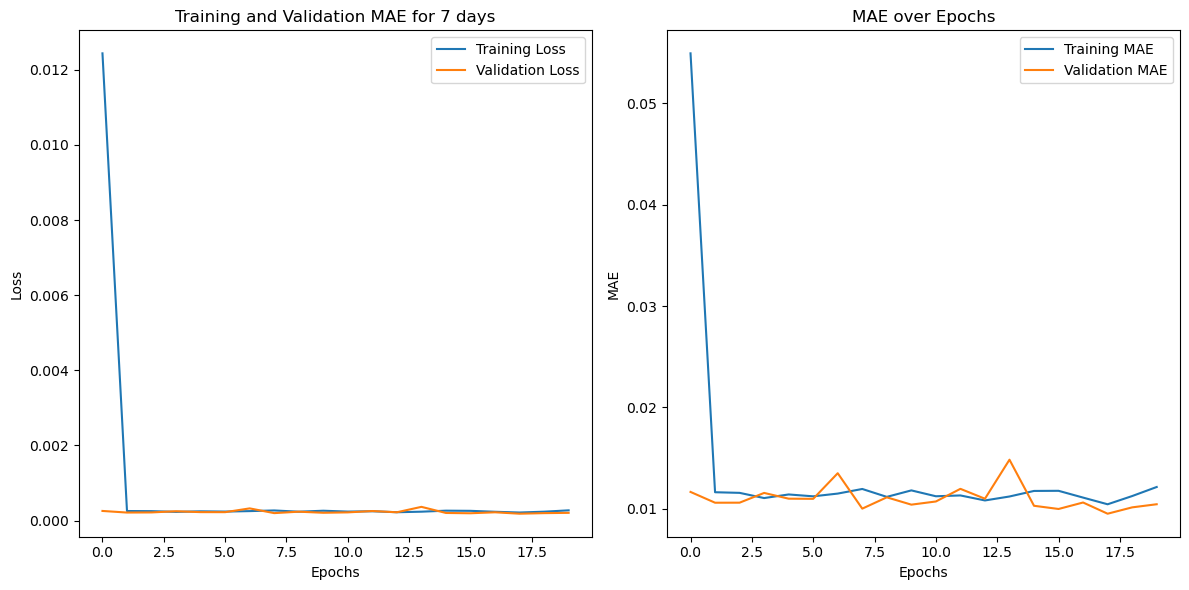

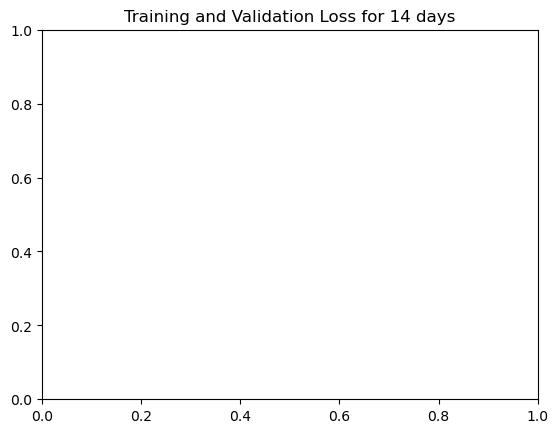

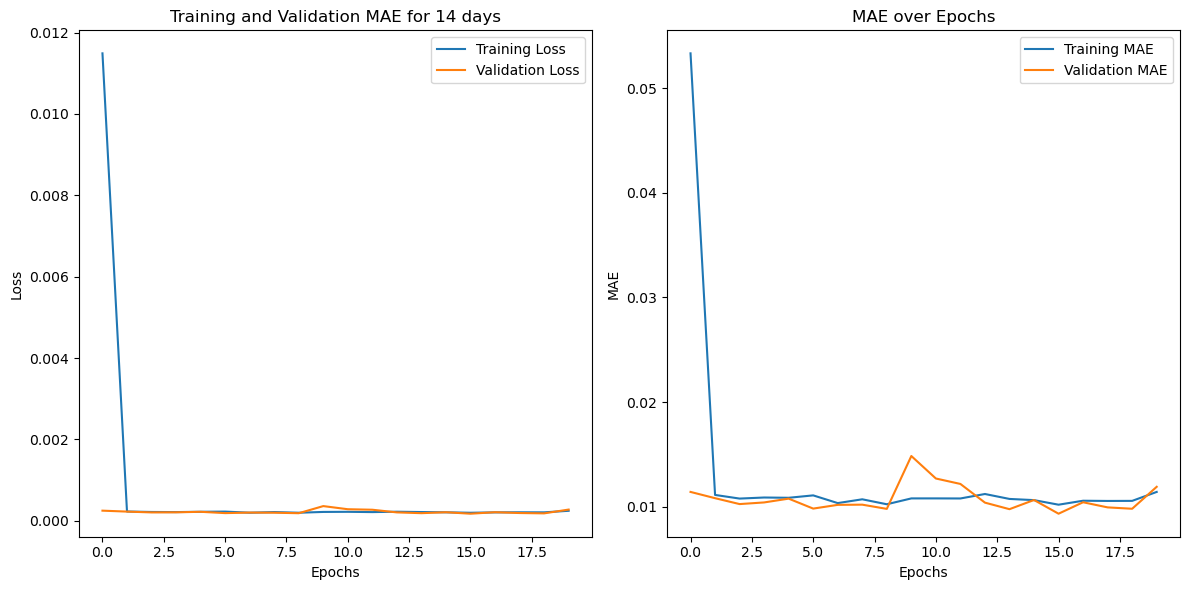

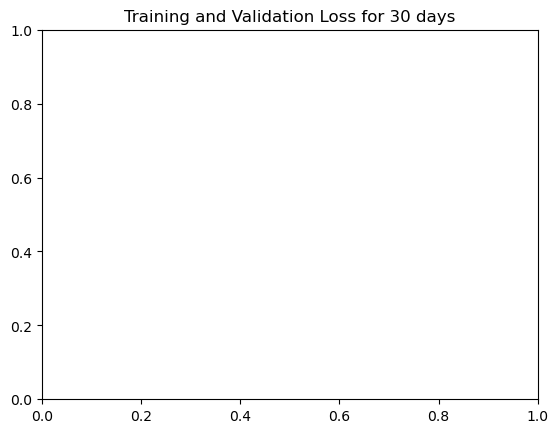

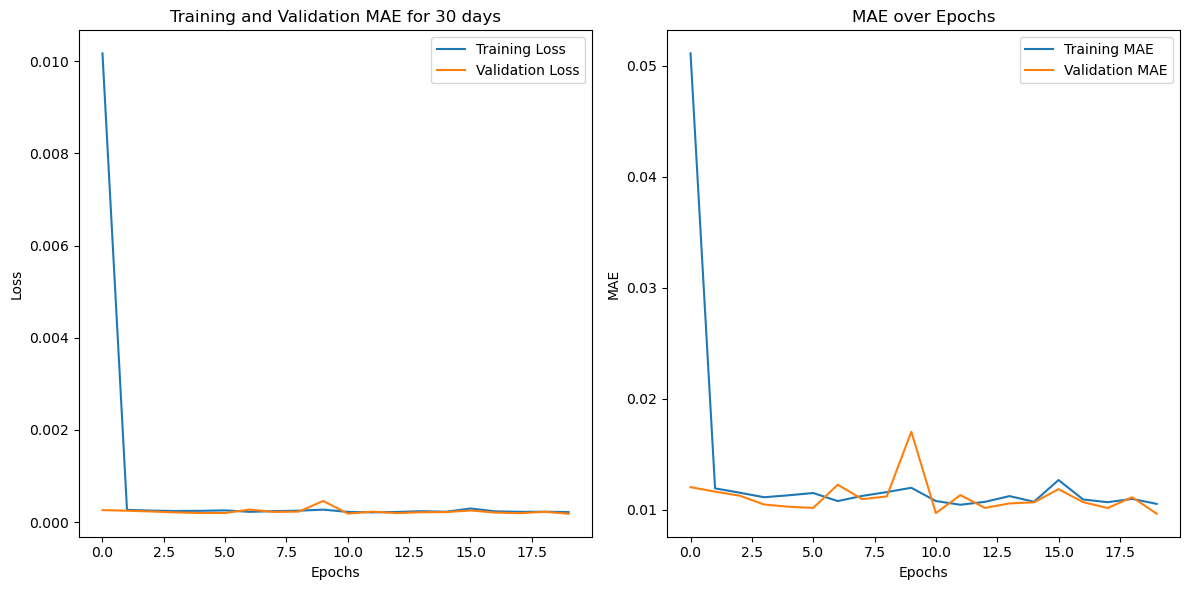

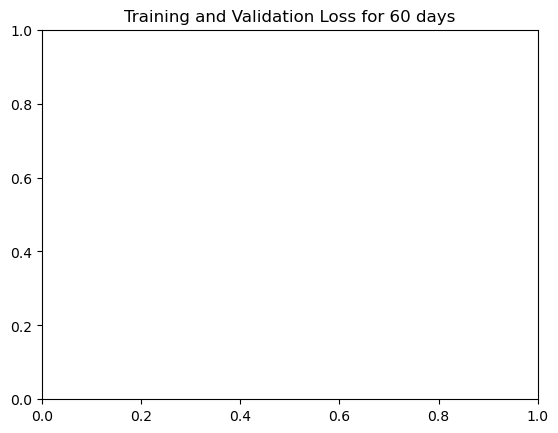

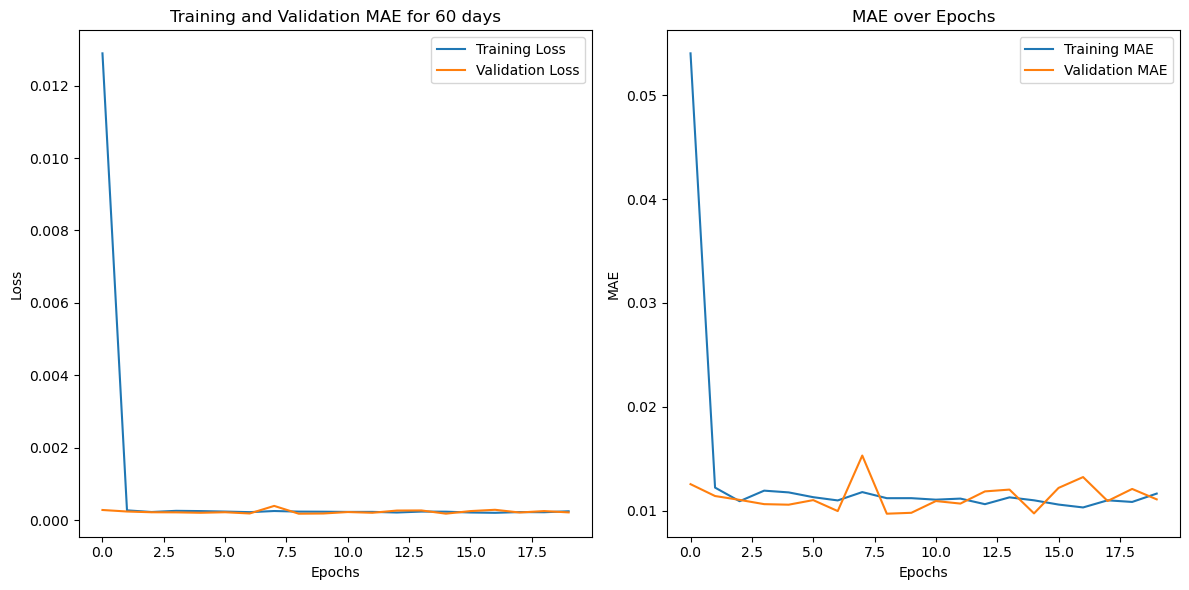

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0736 - mae: 0.1867 - val_loss: 3.7137e-04 - val_mae: 0.0145
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9832e-04 - mae: 0.0150 - val_loss: 2.8313e-04 - val_mae: 0.0121
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3853e-04 - mae: 0.0139 - val_loss: 2.8162e-04 - val_mae: 0.0120
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5081e-04 - mae: 0.0140 - val_loss: 2.6325e-04 - val_mae: 0.0117
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6184e-04 - mae: 0.0140 - val_loss: 2.9269e-04 - val_mae: 0.0128
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0847e-04 - mae: 0.0146 - val_loss: 3.4684e-04 - val_mae: 0.0140
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5358e-04 - mae: 0.0136 - val_loss: 3.8952e-04 - val_mae: 0.0155
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1591e-04 - mae: 0.0133 - val_loss: 3.1549e-04 - val_mae: 0.0137
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0645 - mae: 0.1750 - val_loss: 5.1999e-04 - val_mae: 0.0173
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8660e-04 - mae: 0.0180 - val_loss: 4.7937e-04 - val_mae: 0.0165
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5603e-04 - mae: 0.0195 - val_loss: 4.5980e-04 - val_mae: 0.0160
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8087e-04 - mae: 0.0180 - val_loss: 9.4608e-04 - val_mae: 0.0240
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9343e-04 - mae: 0.0225 - val_loss: 4.6994e-04 - val_mae: 0.0161
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2118e-04 - mae: 0.0200 - val_loss: 0.0025 - val_mae: 0.0387
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7290e-04 - mae: 0.0223 - val_loss: 5.7963e-04 - val_mae: 0.0181
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7312e-04 - mae: 0.0192 - val_loss: 6.6528e-04 - val_mae: 0.0193
Epoch 9/20


Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0369 - mae: 0.1124 - val_loss: 6.8813e-04 - val_mae: 0.0198
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2954e-04 - mae: 0.0229 - val_loss: 6.6483e-04 - val_mae: 0.0195
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.3799e-04 - mae: 0.0231 - val_loss: 6.5633e-04 - val_mae: 0.0196
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2610e-04 - mae: 0.0218 - val_loss: 8.1240e-04 - val_mae: 0.0218
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.1958e-04 - mae: 0.0228 - val_loss: 5.9378e-04 - val_mae: 0.0184
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5061e-04 - mae: 0.0231 - val_loss: 5.6580e-04 - val_mae: 0.0180
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1560e-04 - mae: 0.0198 - val_loss: 9.7955e-04 - val_mae: 0.0248
Epoch 9

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0247 - mae: 0.0923 - val_loss: 9.9051e-04 - val_mae: 0.0249
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.7312e-04 - mae: 0.0237 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0027 - mae: 0.0356 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.4563e-04 - mae: 0.0233 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0012 - mae: 0.0252 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.6482e-04 - mae: 0.0220 - val_loss: 7.8182e-04 - val_mae: 0.0208
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.5788e-04 - mae: 0.0216 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 8.4341e-04 - val_mae: 0.0222
Epoch 9/20
126/126 ━━━━━━━━━━━━

Model trained on 60 days has been saved.


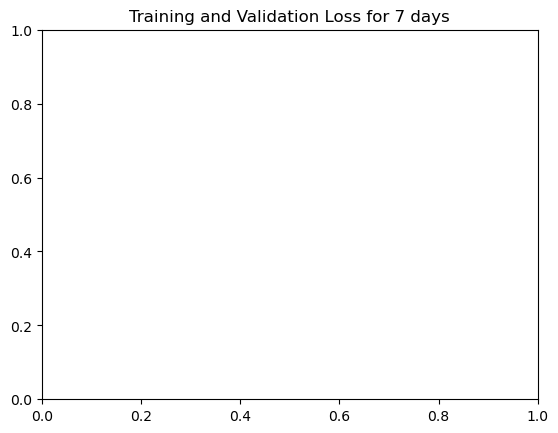

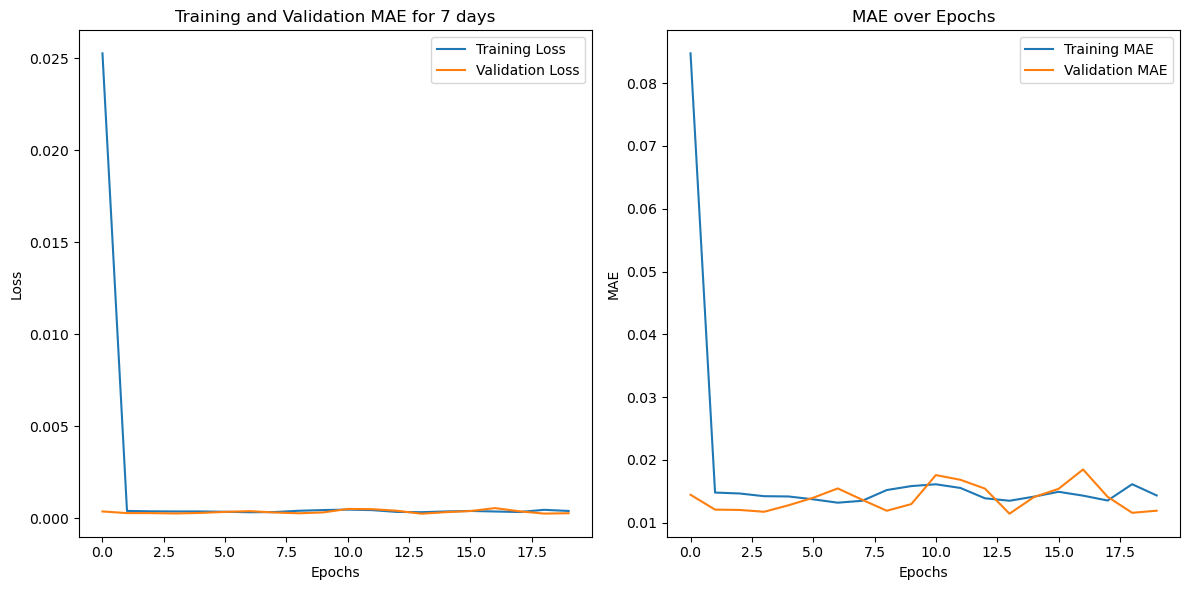

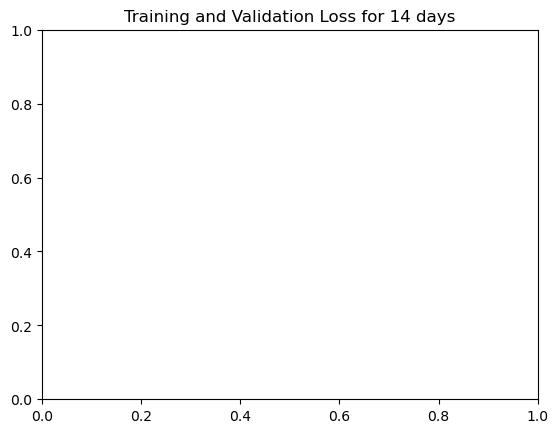

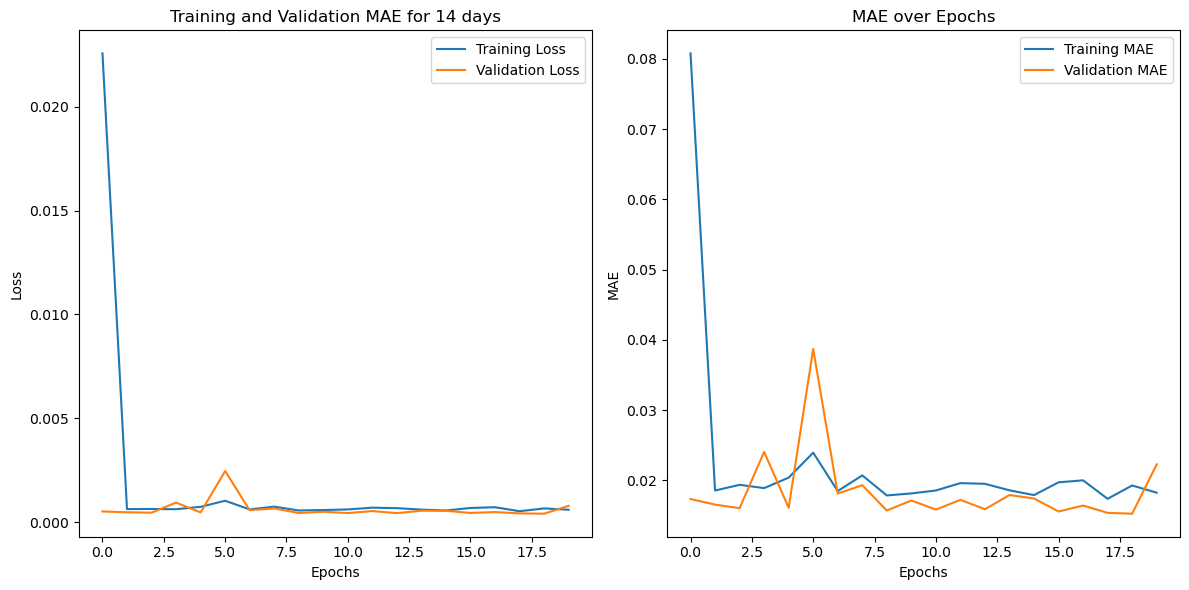

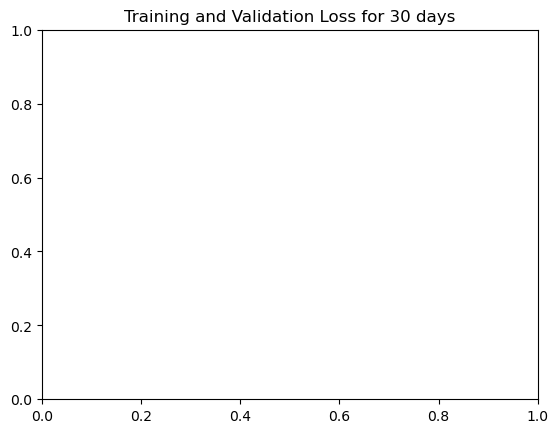

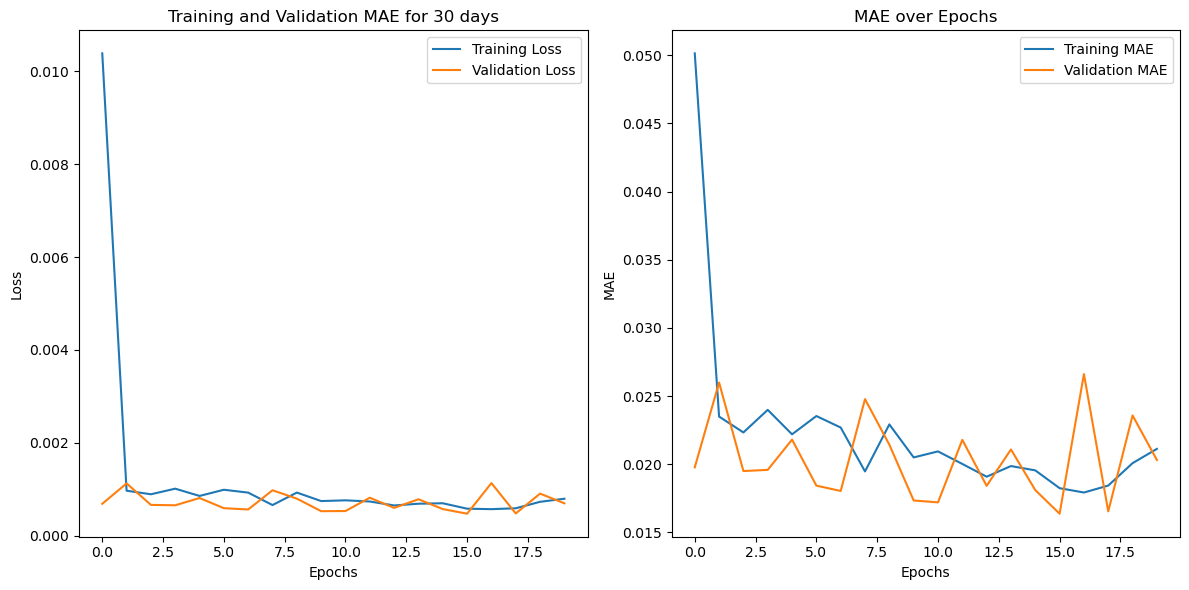

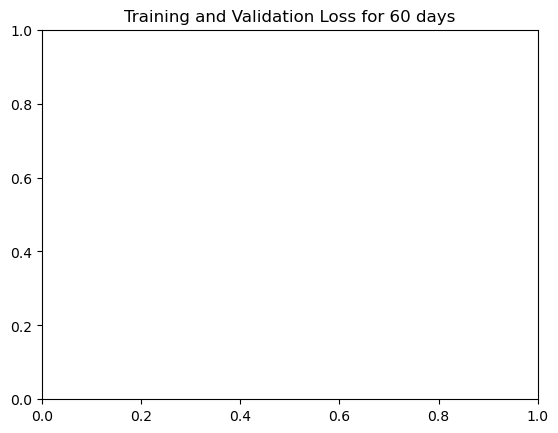

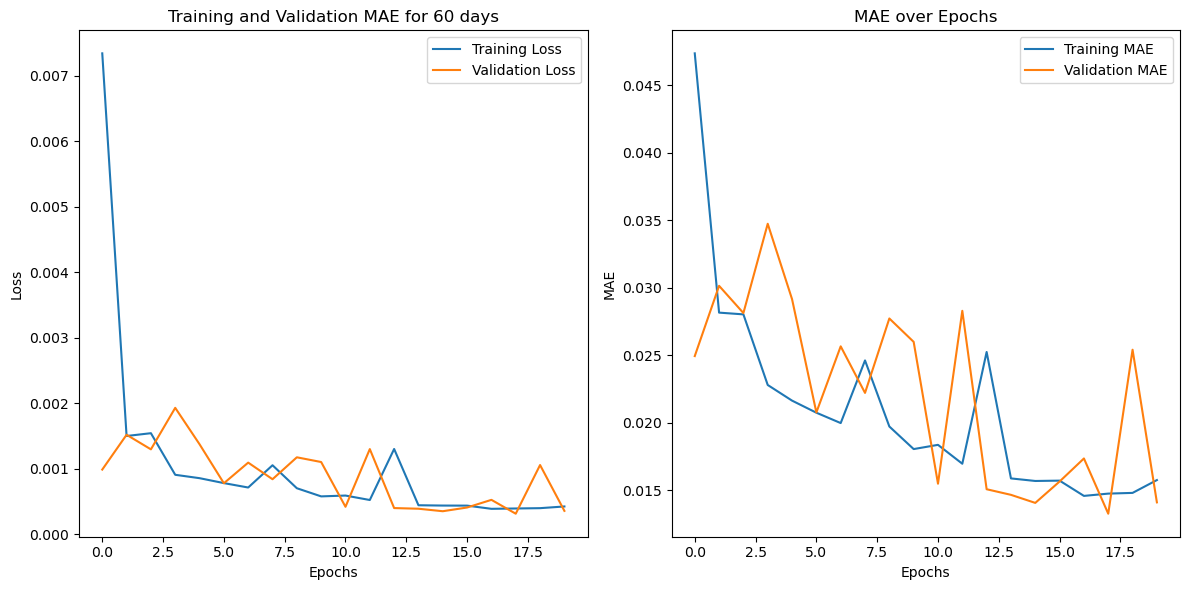

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0523 - mae: 0.1459 - val_loss: 4.1496e-04 - val_mae: 0.0151
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2782e-04 - mae: 0.0131 - val_loss: 2.8181e-04 - val_mae: 0.0123
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5338e-04 - mae: 0.0140 - val_loss: 2.6768e-04 - val_mae: 0.0118
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1918e-04 - mae: 0.0133 - val_loss: 4.9167e-04 - val_mae: 0.0169
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1154e-04 - mae: 0.0129 - val_loss: 3.5416e-04 - val_mae: 0.0139
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7210e-04 - mae: 0.0122 - val_loss: 2.8270e-04 - val_mae: 0.0124
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2331e-04 - mae: 0.0133 - val_loss: 5.3420e-04 - val_mae: 0.0179
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4651e-04 - mae: 0.0139 - val_loss: 2.9096e-04 - val_mae: 0.0126
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0530 - mae: 0.1326 - val_loss: 4.5585e-04 - val_mae: 0.0159
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9858e-04 - mae: 0.0167 - val_loss: 4.7204e-04 - val_mae: 0.0162
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2466e-04 - mae: 0.0170 - val_loss: 4.1009e-04 - val_mae: 0.0149
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1013e-04 - mae: 0.0165 - val_loss: 4.1989e-04 - val_mae: 0.0152
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4821e-04 - mae: 0.0155 - val_loss: 4.4548e-04 - val_mae: 0.0158
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5752e-04 - mae: 0.0183 - val_loss: 8.3360e-04 - val_mae: 0.0223
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7060e-04 - mae: 0.0197 - val_loss: 4.9815e-04 - val_mae: 0.0166
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5313e-04 - mae: 0.0210 - val_loss: 4.2407e-04 - val_mae: 0.0154
Epoch 9

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0339 - mae: 0.1097 - val_loss: 4.9859e-04 - val_mae: 0.0168
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1900e-04 - mae: 0.0184 - val_loss: 5.6789e-04 - val_mae: 0.0174
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3383e-04 - mae: 0.0188 - val_loss: 4.5220e-04 - val_mae: 0.0158
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3085e-04 - mae: 0.0172 - val_loss: 4.3816e-04 - val_mae: 0.0155
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7335e-04 - mae: 0.0190 - val_loss: 8.9727e-04 - val_mae: 0.0234
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5438e-04 - mae: 0.0178 - val_loss: 5.5629e-04 - val_mae: 0.0180
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9313e-04 - mae: 0.0164 - val_loss: 5.3311e-04 - val_mae: 0.0174
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4464e-04 - mae: 0.0186 - val_loss: 5.4430e-04 - val_mae: 0.0173
Epoch 

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0375 - mae: 0.1089 - val_loss: 6.1372e-04 - val_mae: 0.0194
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8810e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9231e-04 - mae: 0.0167 - val_loss: 5.2048e-04 - val_mae: 0.0175
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1777e-04 - mae: 0.0170 - val_loss: 4.6849e-04 - val_mae: 0.0163
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6055e-04 - mae: 0.0186 - val_loss: 3.5329e-04 - val_mae: 0.0139
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1223e-04 - mae: 0.0148 - val_loss: 3.5302e-04 - val_mae: 0.0139
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3620e-04 - mae: 0.0154 - val_loss: 3.4126e-04 - val_mae: 0.0137
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5890e-04 - mae: 0.0139 - val_loss: 4.3227e-04 - val_mae: 0.0154
Epo

Model trained on 60 days has been saved.


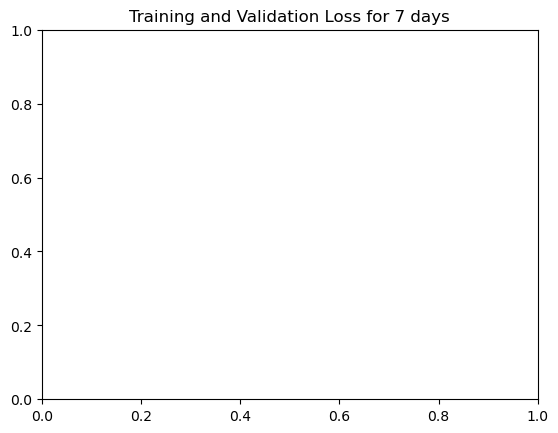

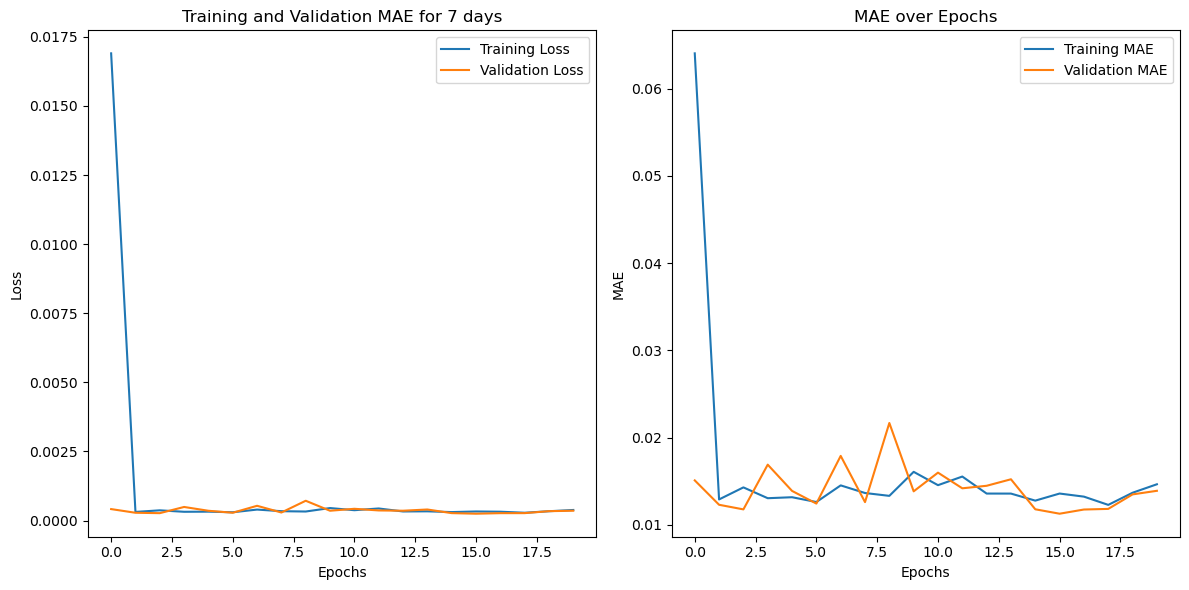

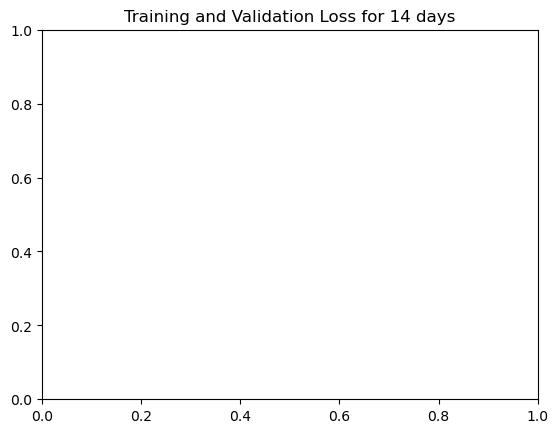

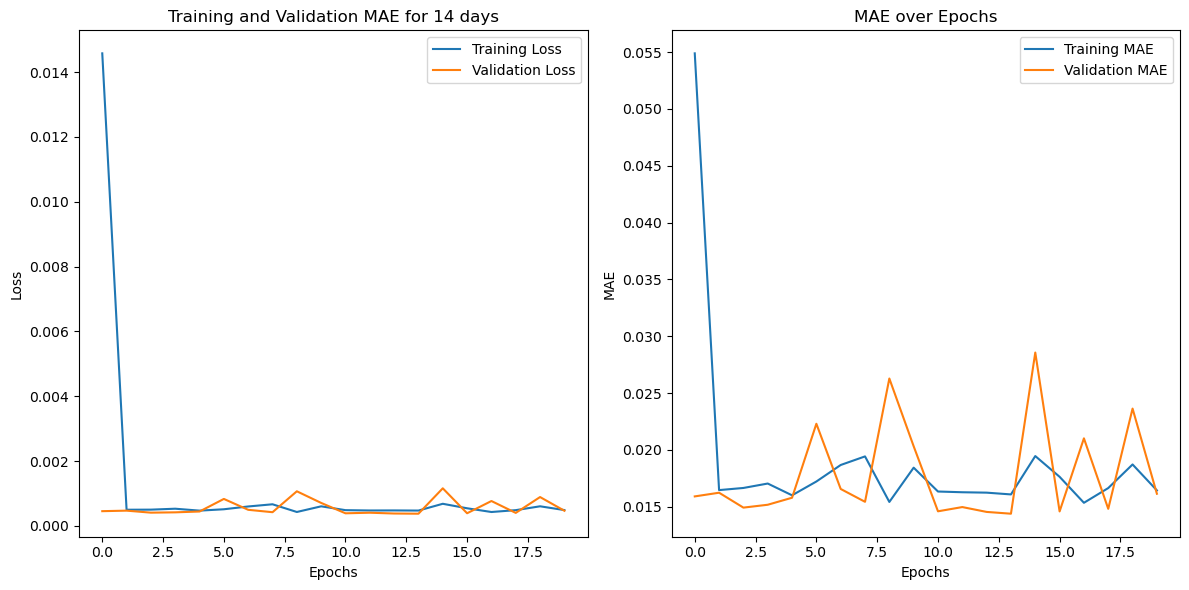

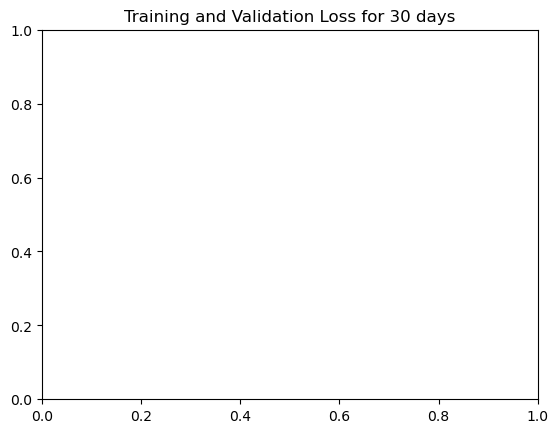

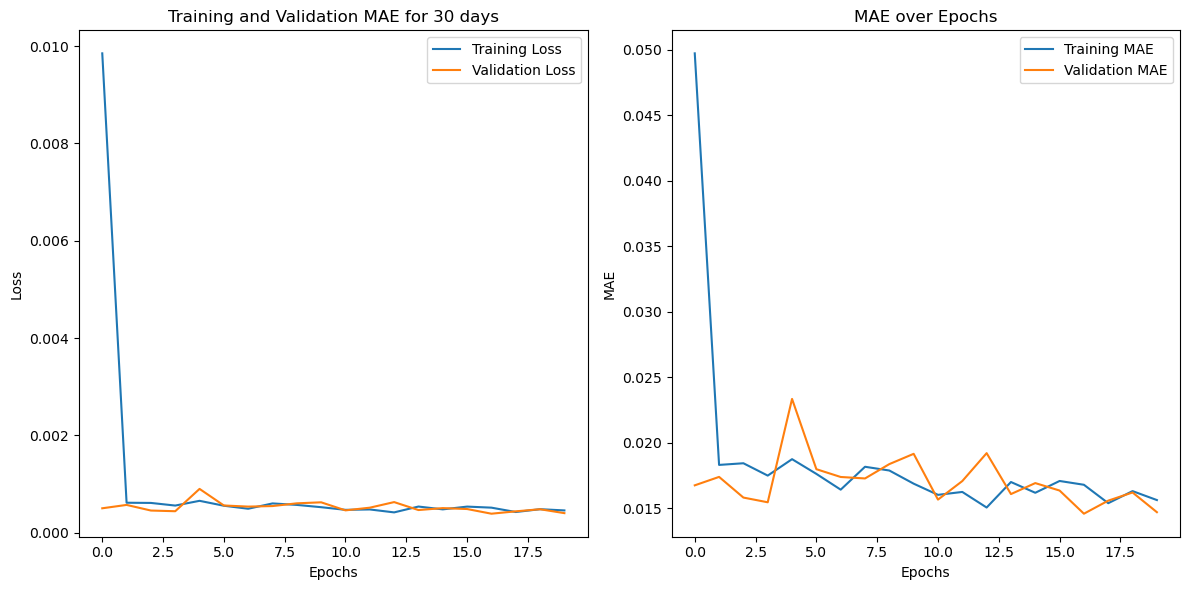

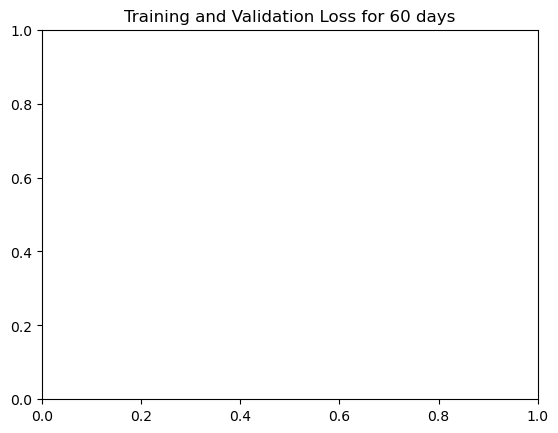

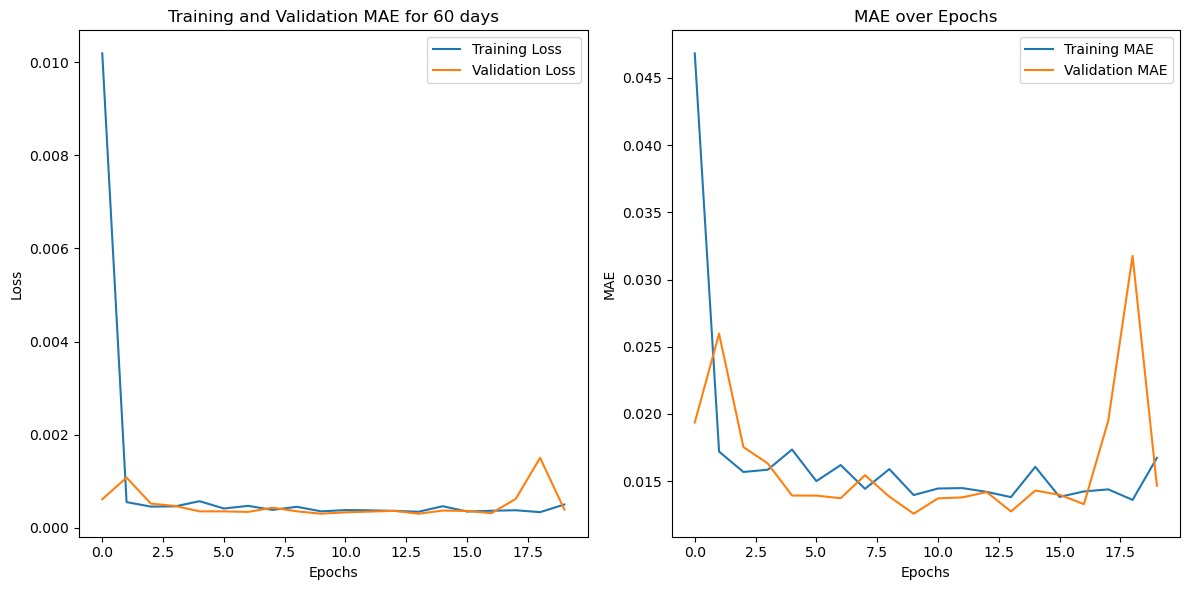

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0629 - mae: 0.1694 - val_loss: 3.6553e-04 - val_mae: 0.0144
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2740e-04 - mae: 0.0156 - val_loss: 4.9093e-04 - val_mae: 0.0167
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5977e-04 - mae: 0.0141 - val_loss: 2.8460e-04 - val_mae: 0.0122
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6870e-04 - mae: 0.0142 - val_loss: 4.1778e-04 - val_mae: 0.0158
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5374e-04 - mae: 0.0141 - val_loss: 4.7413e-04 - val_mae: 0.0167
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5760e-04 - mae: 0.0142 - val_loss: 3.0912e-04 - val_mae: 0.0130
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6099e-04 - mae: 0.0181 - val_loss: 5.3193e-04 - val_mae: 0.0182
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6707e-04 - mae: 0.0161 - val_loss: 5.3602e-04 - val_mae: 0.0189
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0680 - mae: 0.1669 - val_loss: 6.6345e-04 - val_mae: 0.0198
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2211e-04 - mae: 0.0203 - val_loss: 5.3181e-04 - val_mae: 0.0175
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6286e-04 - mae: 0.0195 - val_loss: 6.2986e-04 - val_mae: 0.0191
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6694e-04 - mae: 0.0184 - val_loss: 5.7774e-04 - val_mae: 0.0181
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7811e-04 - mae: 0.0195 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7839e-04 - mae: 0.0197 - val_loss: 7.2559e-04 - val_mae: 0.0203
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4857e-04 - mae: 0.0190 - val_loss: 0.0011 - val_mae: 0.0252
Epoch

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0514 - mae: 0.1376 - val_loss: 0.0013 - val_mae: 0.0283
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9034e-04 - mae: 0.0239 - val_loss: 8.3765e-04 - val_mae: 0.0225
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9555e-04 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0011 - val_mae: 0.0248
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.0491e-04 - mae: 0.0222 - val_loss: 0.0029 - val_mae: 0.0443
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0251 - val_loss: 7.1015e-04 - val_mae: 0.0204
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2392e-04 - mae: 0.0215 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 8/20
126/12

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0413 - mae: 0.1136 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0017 - mae: 0.0313 - val_loss: 0.0019 - val_mae: 0.0343
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0015 - val_mae: 0.0285
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014 - mae: 0.0277 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 9.6936e-04 - val_mae: 0.0240
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0015 - mae: 0.0294 - val_loss: 9.6038e-04 - val_mae: 0.0238
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 9.4334e-04 - val_mae: 0.0240
Epoch 8/20
126/126 ━━━━━━━━━━

Model trained on 60 days has been saved.


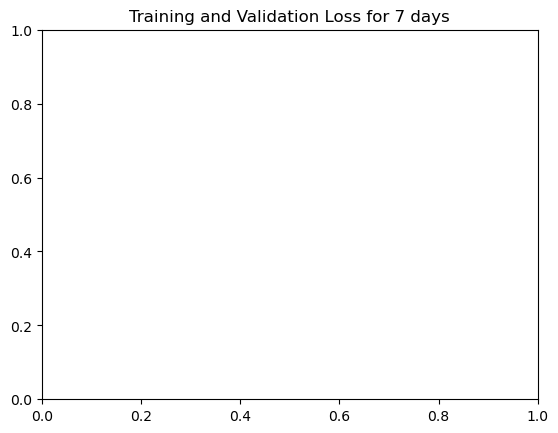

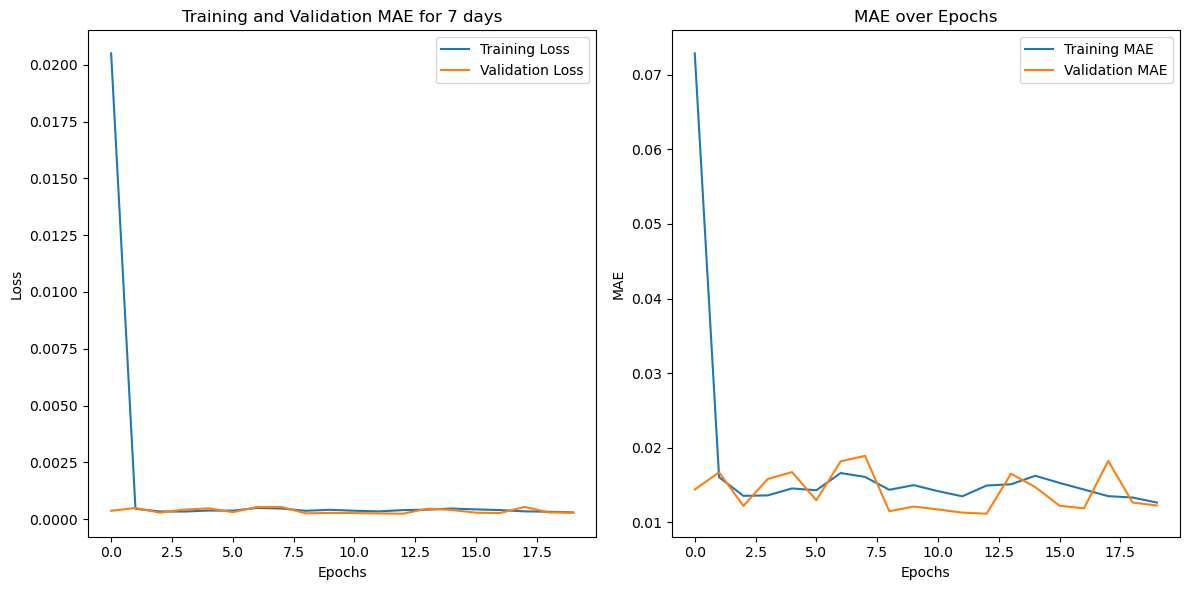

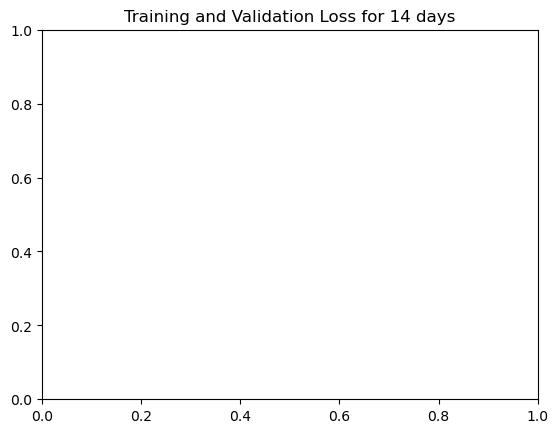

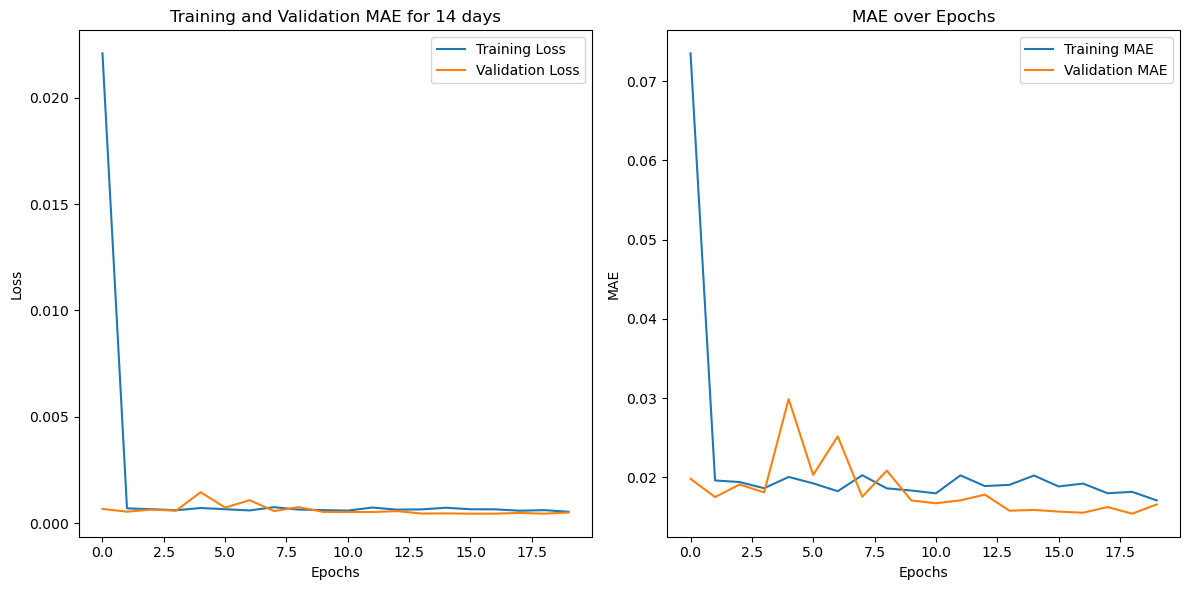

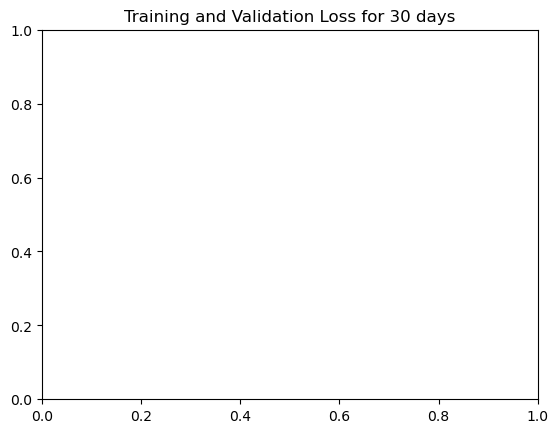

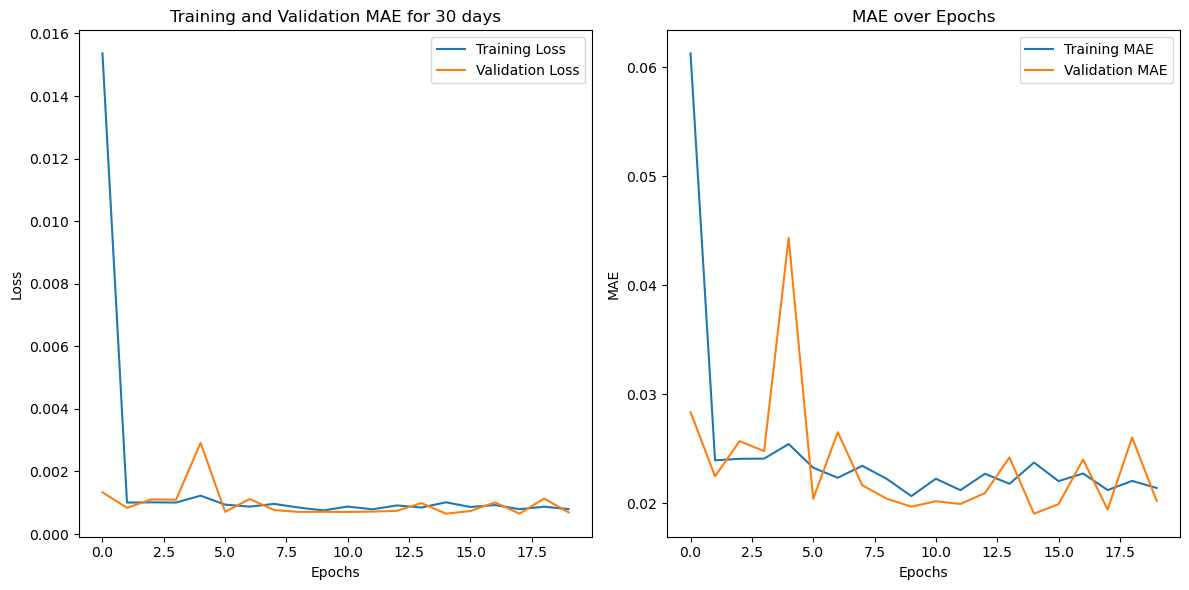

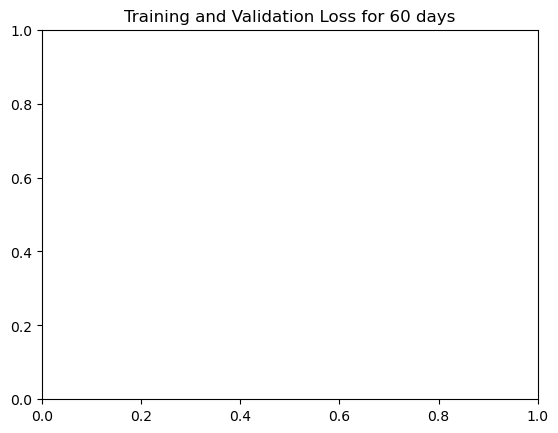

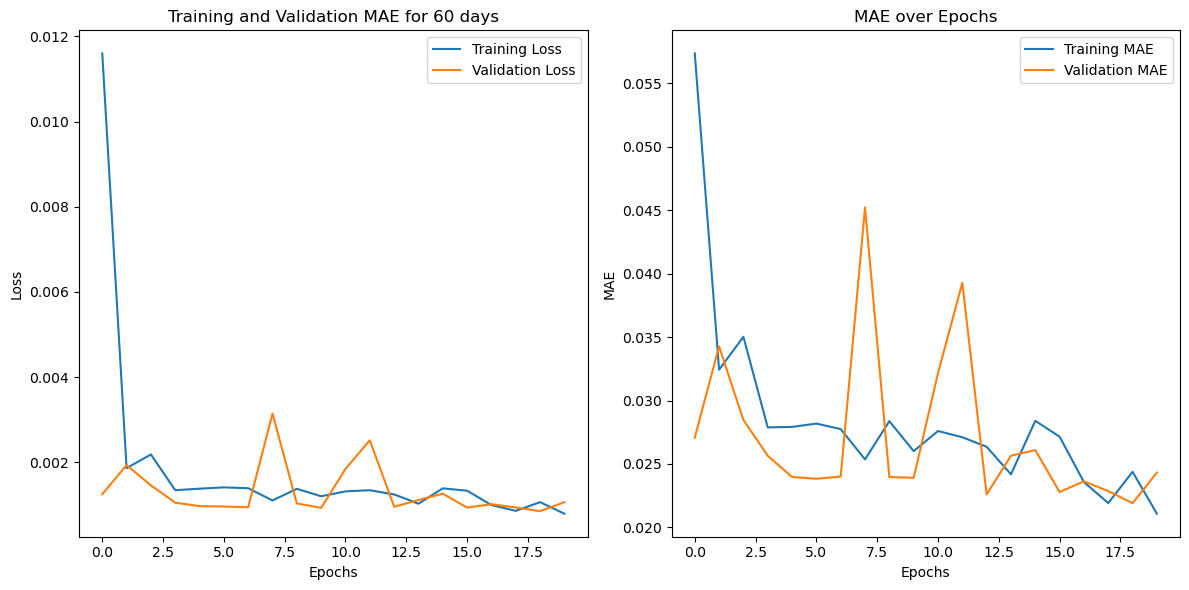

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0465 - mae: 0.1327 - val_loss: 2.9221e-04 - val_mae: 0.0125
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5224e-04 - mae: 0.0134 - val_loss: 6.1336e-04 - val_mae: 0.0195
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9835e-04 - mae: 0.0148 - val_loss: 3.4329e-04 - val_mae: 0.0139
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3758e-04 - mae: 0.0135 - val_loss: 5.2212e-04 - val_mae: 0.0178
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6072e-04 - mae: 0.0139 - val_loss: 2.8304e-04 - val_mae: 0.0124
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9522e-04 - mae: 0.0147 - val_loss: 5.1066e-04 - val_mae: 0.0173
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4391e-04 - mae: 0.0140 - val_loss: 3.9705e-04 - val_mae: 0.0149
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9241e-04 - mae: 0.0161 - val_loss: 2.9603e-04 - val_mae: 0.0129
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0433 - mae: 0.1241 - val_loss: 4.6637e-04 - val_mae: 0.0162
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0731e-04 - mae: 0.0168 - val_loss: 4.4306e-04 - val_mae: 0.0156
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8478e-04 - mae: 0.0168 - val_loss: 4.5311e-04 - val_mae: 0.0158
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4156e-04 - mae: 0.0170 - val_loss: 5.4548e-04 - val_mae: 0.0175
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9514e-04 - mae: 0.0200 - val_loss: 4.2836e-04 - val_mae: 0.0154
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7760e-04 - mae: 0.0175 - val_loss: 5.2241e-04 - val_mae: 0.0171
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7461e-04 - mae: 0.0178 - val_loss: 9.9124e-04 - val_mae: 0.02

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0414 - mae: 0.1303 - val_loss: 9.4131e-04 - val_mae: 0.0240
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3718e-04 - mae: 0.0207 - val_loss: 6.5273e-04 - val_mae: 0.0196
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7935e-04 - mae: 0.0212 - val_loss: 6.6741e-04 - val_mae: 0.0192
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9657e-04 - mae: 0.0198 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3607e-04 - mae: 0.0227 - val_loss: 5.8907e-04 - val_mae: 0.0183
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5328e-04 - mae: 0.0190 - val_loss: 7.8917e-04 - val_mae: 0.0219
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.1942e-04 - mae: 0.0216 - val_loss: 6.2569e-04 - val_mae: 0.0191


Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0278 - mae: 0.1052 - val_loss: 0.0013 - val_mae: 0.0262
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 8.7455e-04 - val_mae: 0.0231
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9871e-04 - mae: 0.0240 - val_loss: 8.6569e-04 - val_mae: 0.0221
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0010 - val_mae: 0.0236
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - mae: 0.0337 - val_loss: 0.0027 - val_mae: 0.0401
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - mae: 0.0306 - val_loss: 7.8731e-04 - val_mae: 0.0217
Epoch 8/20
126/126 ━━━━━━

Model trained on 60 days has been saved.


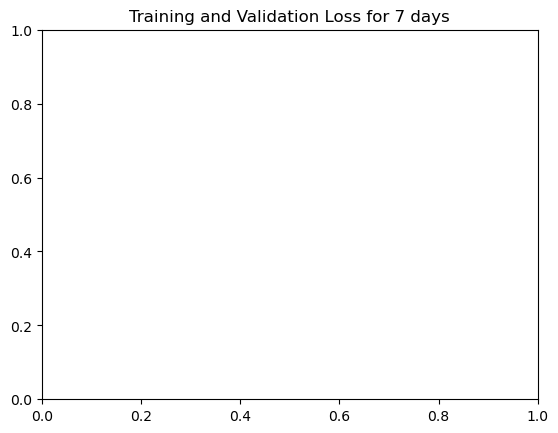

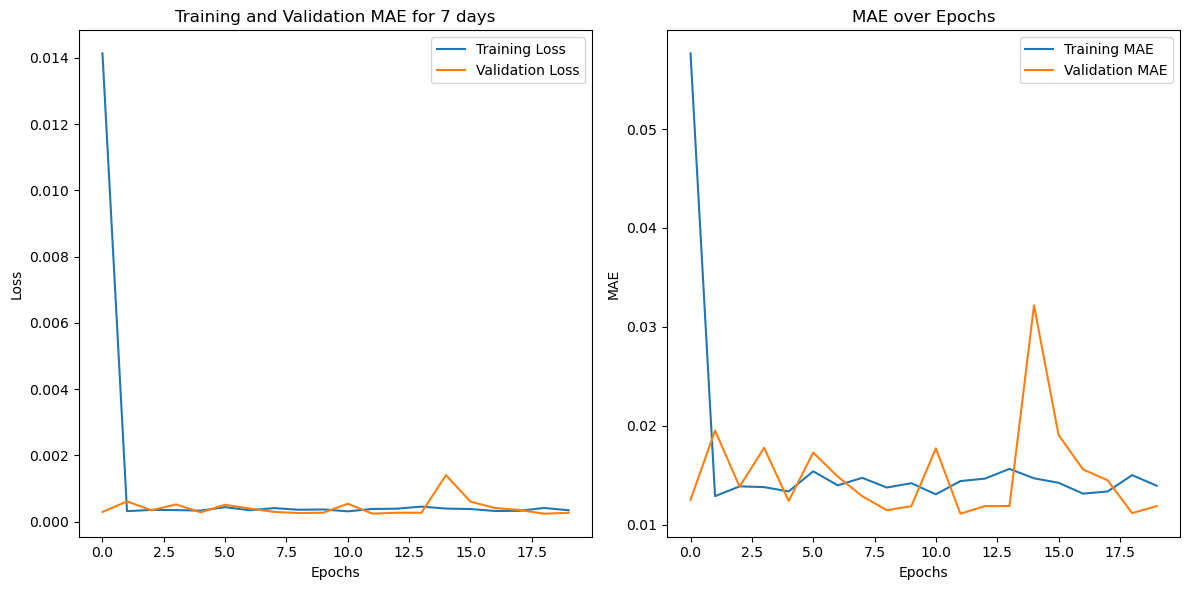

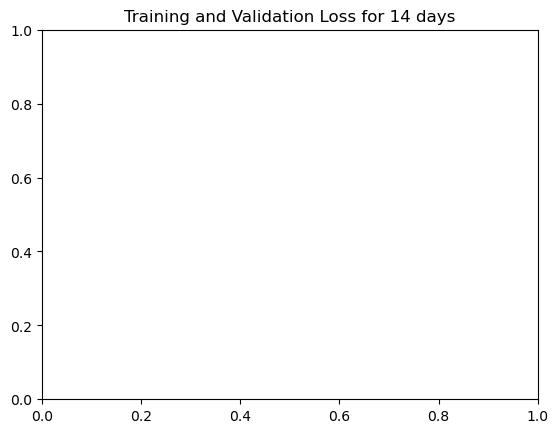

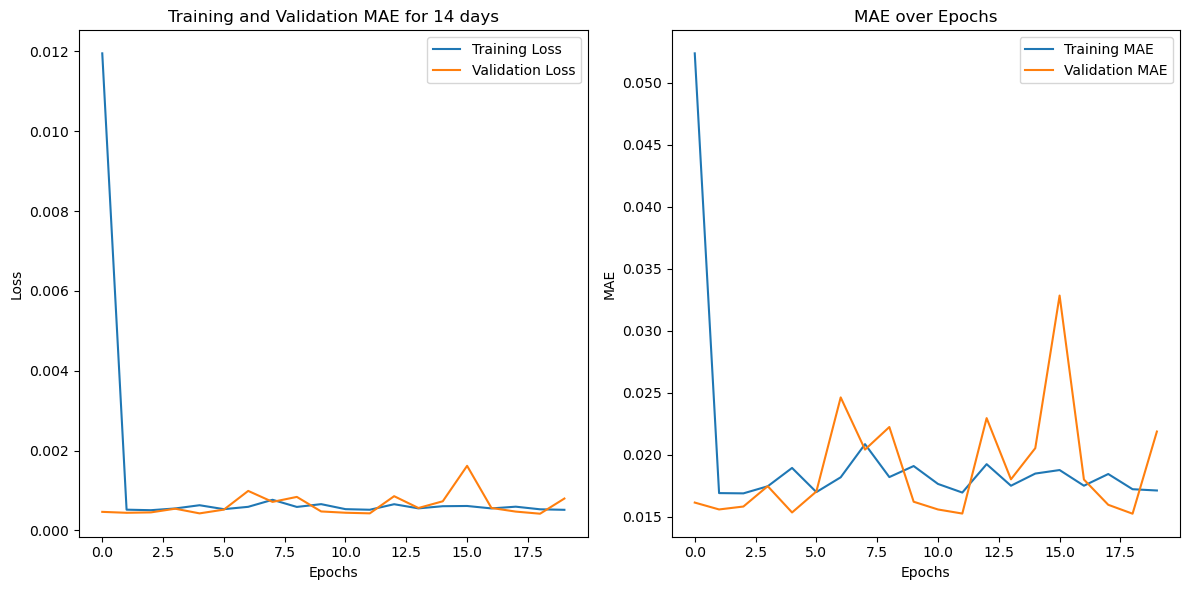

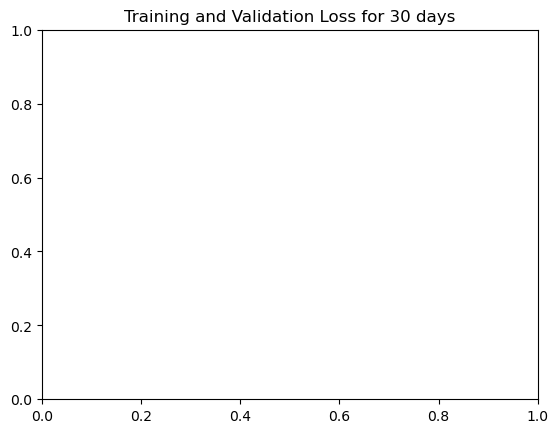

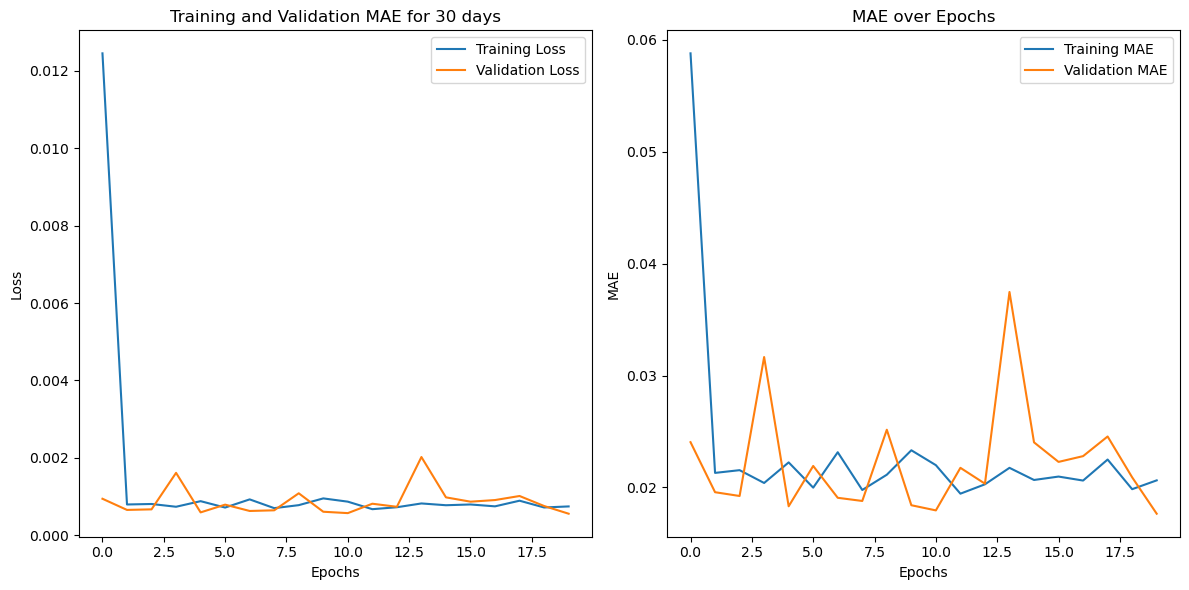

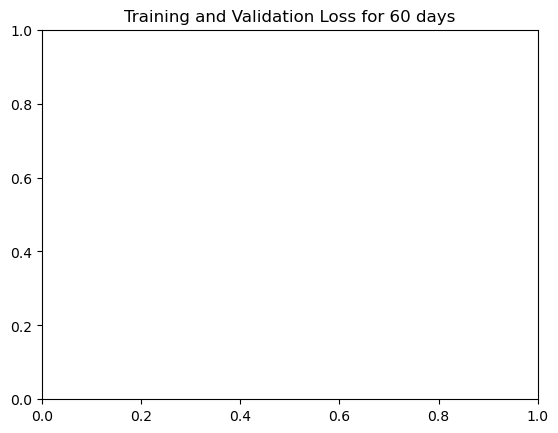

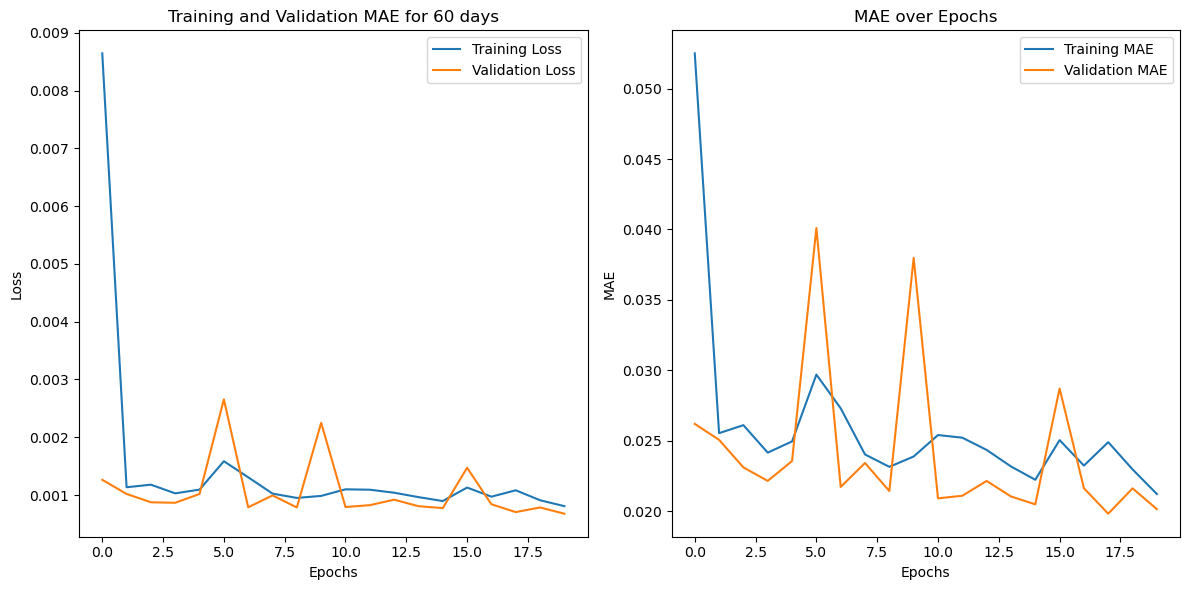

In [12]:
function_list = [baseline_LSTM_model, 
                 baseline_GRU_model, 
                 CNN_LSTM_model, 
                 CNN_GRU_model, 
                 CNN_LSTM_SA_model, 
                 CNN_GRU_SA_model]
for model_function in function_list:
    model_history = meta_training(model_function, 
                                  loading_path = "/Users/hoyinchui/Desktop/tbot-st-ta/Testing data/GLD_model_testing_data_i_v5_pkl/", 
                                  saving_path="/Users/hoyinchui/Desktop/tbot-st-ta/saved models/",
                                  version_name="20250128"
                                  )
    plot_training_history(model_history)

Build ensemble model with meta mode (transfer learning/fine-tuning), since will do back propaggation through the ensemble layer all the way to the individual model, we can use multiple stock training data for the individual model, increase the generalization, and do the tuning with the target data, in the ensemble layer training part

In [9]:
from tensorflow.keras.models import Model
def ensemble_stacking (models,output_days, output_features):
    models_inputs = [] 
    models_outputs = []
    for model in models:
        model = models.load_model(model)
        models_inputs.append(model.input)
        models_outputs.append(model.output)
    merged_output = layers.concatenate(models_outputs, axis=-1)
    #searching method for removing the last layer of the model, and directly inputting weight into stackinng model
    
    #stacking model
    merged_output = layers.Dense(64, activation='relu')(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return ensemble_model


    

In [ ]:
def ensemble_weighting (models,output_days, output_features):
    models_inputs = [] 
    models_outputs = []
    for model in models:
        model = models.load_model(model)
        models_inputs.append(model.input)
        models_outputs.append(model.output)
    merged_output = layers.Add()(models_outputs)
    merged_output = layers.Dense(1)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return ensemble_model


In [10]:
#need more understanding on the MoE
''' stacking is y_p = sum(w*y_i)
    MoE is y_p = sum(g_i*y_i)
    can add other function model, like anomaly detection, to the ensemble model, since most of the data is normal, the model can be used to detect the anomaly data(Event)
'''
def ensemble_MoE (models,output_days, output_features):
    models_inputs = [] 
    models_outputs = []
    for model in models:
        model = models.load_model(model)
        models_inputs.append(model.input)
        models_outputs.append(model.output)
    merged_output = layers.Add()(models_outputs)
    gate = layers.Dense(len(models), activation='softmax')(merged_output)
    expert_outputs = layers.Multiply()([gate, models_outputs])
    final_output = layers.Reshape((output_days, output_features))(expert_outputs)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return ensemble_model

In [ ]:
def loading_models (models):
    loaded_models = []
    for model in models:
        loaded_model = models.load_model(model)
        loaded_models.append(loaded_model)
    return loaded_models

### the following 3 cell can skip, theey are old version for reference

In [ ]:
#load the model and predict and save the prediction
#for window in window_size:
#    model = tf.keras.models.load_model(f"CNN_LSTM_{window}days.h5")
#    y_pred = model.predict(X_test)
#    pd.DataFrame(y_pred).to_csv(f"y_pred_CNN_LSTM_{window}days.csv")

In [ ]:
#putting all windows prediction into the dataframe as X
#import numpy as np
#X_ensemble = pd.DataFrame()
#for window in window_size:
#    X_ensemble = pd.concat([X_ensemble, pd.read_csv(f"y_pred_CNN_LSTM_{window}days.csv")], axis=1)
#    #combein the columns, so that can be used as input for the ensemble model
#   X_ensemble = X_ensemble.applymap(lambda x: np.vstack(x))

They can combein in 1 for loop, I just split it for clear

In [ ]:
#def train_test_split_ensemble(X,y,test_size=0.5, seed=42):    
#    #split again for the prediction model and the ensemble model
#    #Since we already shuffled the data, we can just split the data in half, and easaier to manage
#    X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=seed)
#    return X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble

In [ ]:
#X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split_ensemble(X_ensemble, y_test)

### Ensemble Model (TBC)

In [3]:
#from tensorflow.keras.models import Model
#def ensemble_CNN_LSTM(window_size, num_features):
#    inputs = layers.Input(shape=(window_size, num_features))
#    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.LSTM(100)(x)
#    model = Model(inputs=inputs, outputs=x)
#    return model

In [ ]:
#def ensemble_s_models(window_size, num_features, output_days, output_features):
#        models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)

In [ ]:
#def ensemble_MoE_models(window_size, num_features, output_days, output_features):


In [4]:
#def ensemble_h_models(window_size, num_features, output_days, output_features):
#    models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)
#    models_inputs = [model.input for model in models]
#    models_outputs = [model.output for model in models]
#   merged = layers.concatenate(models_outputs, axis=-1)
#    merged_output = layers.Dense(output_days * output_features)(merged)
#    final_output = layers.Reshape((output_days, output_features))(merged_output)
#    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
#    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#
#    return ensemble_model

In [6]:
#from sklearn.model_selection import train_test_split
#import pandas as pd
#seed = 42
#test_size = 0.8 # we need to consider for the ensemble model's training and ttesting data, since it cannot use the same training data
#epochs = 20
#batch_size = 8
#shuffle=True
#all_X_train = []
#all_X_test = []
#all_y_train = []
#all_y_test = []
#
#y = pd.read_pickle(f"/Users/hoyinchui/Downloads/y_a.pkl")
#for window in window_size:
#    X = pd.read_pickle(f"/Users/hoyinchui/Downloads/X_{window}days_a.pkl")
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
#    all_X_train.append(X_train)
#    all_X_test.append(X_test)
#    all_y_train.append(y_train)
#    all_y_test.append(y_test)
#
##ensemble_model = ensemble_h_models(window_size, num_features, output_days, output_features)
##history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, validation_data=(all_X_test, all_y_test[0]), verbose=1)
##ensemble_model.save(f"ensemble_CNN_LSTM.h5")
#

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0279 - mae: 0.1027 - val_loss: 5.5140e-04 - val_mae: 0.0176
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.2824e-04 - mae: 0.0169 - val_loss: 4.1390e-04 - val_mae: 0.0154
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.1239e-04 - mae: 0.0167 - val_loss: 4.6971e-04 - val_mae: 0.0162
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4.3028e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.6607e-04 - mae: 0.0210 - val_loss: 4.8477e-04 - val_mae: 0.0170
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.1826e-04 - mae: 0.0152 - val_loss: 3.3729e-04 - val_mae: 0.0135
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.9106e-04 - mae: 0.0147 - val_loss: 5.9622e-04 - val_mae: 0.0190
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.8556e-04 - mae: 0.0144 - val_loss: 3.2576e-04 - val_mae: